<br>

## 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
train_origin = pd.read_csv('train.csv', index_col=0)
train = pd.read_csv('train_x_0.2_99.8.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

# Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train_origin['type_num'] = train_origin['type'].apply(lambda x : to_number(x, column_number))

# 모델에 적용할 데이터 셋 준비 
x = train
y = train_origin['type_num']

x = x.drop(columns=['fiberID'], axis=1)
test_x = test.drop(columns=['fiberID'],axis=1)

col_name = x.columns

x = np.array(x)
x = x.astype('float32')

y = np.array(y)

test_x = np.array(test_x)
test_x = test_x.astype('float32')

from sklearn.model_selection import train_test_split, KFold
x_train, x_test, y_train, y_test = train_test_split(x,y, 
                                                    train_size=0.7, 
                                                    shuffle=True ,
                                                    random_state=0)

from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()

scaler2.fit(x_train)
x_train = scaler2.transform(x_train)
x_test = scaler2.transform(x_test)

test_x = scaler2.transform(test_x)

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

C:\Users\student\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Using TensorFlow backend.


<br>

## 모델링

In [2]:
# 모델링
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from keras.initializers import he_normal
from keras.optimizers import adam

num_classes = 19

model=Sequential()

model.add(Dense(64,input_shape=(20, ))) # input dimension
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
# model.add(Dense(128, kernel_initializer=, kernel_regularizer=l2(0.01), bias_regularizer= l2(0.01), bias_initializer=))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(0.1))

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

<br>

## Learning Rate Finder

In [3]:
# 모델 훈련
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train, y_train, batch_size=38, epochs=50, verbose=2,validation_split=0.25)
loss, acc = model.evaluate(x_test,y_test,batch_size=64)
print('Loss:',loss,'Accuracy:',acc)

In [6]:
# LRFinder 사용
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, 0.0001, 1, 200, 5)

Epoch 1/5
139993/139993 [==============================] - 4s 30us/step - loss: 1.5233 - accuracy: 0.5460
Epoch 2/5
139993/139993 [==============================] - 4s 30us/step - loss: 0.6749 - accuracy: 0.7878
Epoch 3/5
139993/139993 [==============================] - 4s 30us/step - loss: 0.7033 - accuracy: 0.7783
Epoch 4/5
  5400/139993 [>.............................] - ETA: 4s - loss: 1.0979 - accuracy: 0.6852

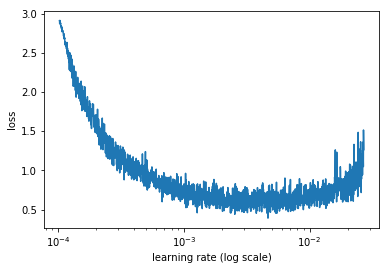

In [7]:
lr_finder.plot_loss()  # n_skip_beginning=10, n_skip_end=5

- 위 Finder의 결과로 학습을 잘하는 Learning Rate 구간은 [Min==1e-2 / Max==1e-4] 임을 알 수있다.